## Replicate model in Preisler et al. (2017)

Their approach was to use a general additive model with a logit link function. GAMs are hard to implement in Python and do not play well with tensorflow. We will approximate this with a dense neural network with a logit activation function in the output node.

In [1]:
import os

if "notebooks" in os.getcwd():
    os.chdir("..")
    print("Changed working directory to", os.getcwd())

import util

import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import cartopy.crs as ccrs

import shutil
import json
import random

from google.cloud.storage import Client

Changed working directory to /home/jovyan/ForestLST


2025-01-10 23:50:51.530350: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-10 23:50:51.548335: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-10 23:50:51.553888: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-10 23:50:51.566620: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/jovyan/ForestLST/util

### Get data from GCS

In [2]:
ds = util.data.make_preisler_dataframe().reset_index()
ds.head()

,latitude,longitude,year,fire,mort,mort1,mtemp1,near1,prec1,prec2,prec3,prec4,prism_prec,rhost1
0,32.597501,-116.691155,2013,0.0,0.0,0.0,-0.216653,0.0000,369.805910,439.905603,480.046706,265.648307,415.772351,0.0
1,32.597501,-116.691155,2014,0.0,0.0,0.0,-2.696189,0.0000,247.394694,369.805910,439.905603,480.046706,415.772351,0.0
2,32.597501,-116.655223,2012,0.0,0.0,0.0,-1.278424,0.0000,448.261502,487.811619,267.075369,285.700573,417.824220,0.0
3,32.597501,-116.655223,2013,0.0,0.0,0.0,-0.367448,0.0000,364.210992,448.261502,487.811619,267.075369,417.824220,0.0
4,32.597501,-116.655223,2014,0.0,0.0,0.0,-3.270955,0.0016,257.534478,364.210992,448.261502,487.811619,417.824220,0.0


### Train-validate-test split

Since tree mortality is autocorrelated, we have to make sure the train and validation sets are spatially disjoint. For ease of display, we arbitrarily pick two years of data as the test set.

*Note that the year column corresponds to the mortality observation and all other columns are shifted back in time.*

In [3]:
test_years = [2005, 2015] # np.random.randint(ds.year.min(), ds.year.max()+1, size=2)
print("Years in test set:", test_years)

test_indices = ds.year.isin(test_years)

ds_test     = ds[ test_indices].copy()
ds_trainval = ds[~test_indices].copy()

Years in test set: [2005, 2015]


Now we assign the remaining observations to 0.25 degree x 0.25 degree blocks. Each block is assigned to training or validation.

In [4]:
ds_trainval["block"] = (
    np.floor(ds_trainval.latitude*4).astype(str) + 
    np.floor(ds_trainval.longitude*4).astype(str) +
    (ds_trainval.year // 5).astype(str)
)
blocks = ds_trainval.block.unique()

p_train = 0.9
train_blocks = np.random.choice(blocks, size=int(blocks.shape[0] * p_train))

ds_trainval["in_training"] = ds_trainval.block.isin(train_blocks)

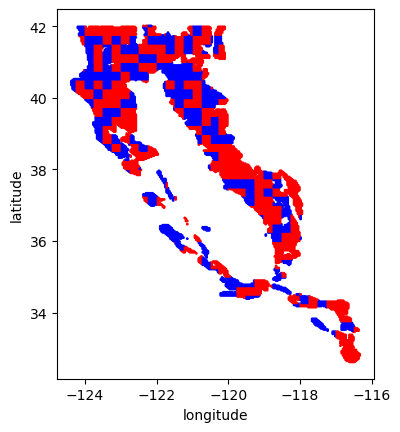

In [5]:
# Plot to make sure we did it right
unique_points = ds_trainval[ds_trainval.year == 2010].drop_duplicates(subset=["latitude", "longitude"])
col = unique_points.in_training.map({False:'b', True:'r'})

ax = unique_points.plot.scatter(x="longitude", y="latitude", c=col, s=1)
ax.set_aspect("equal")
plt.show()

In [6]:
ds_train = ds_trainval[ ds_trainval.in_training]
ds_valid = ds_trainval[~ds_trainval.in_training]

print("Number of rows in")
print("Training:", ds_train.shape[0])
print("Validation:", ds_valid.shape[0])
print("Testing:", ds_test.shape[0])

Number of rows in
Training: 113993
Validation: 80864
Testing: 23485


In [7]:
# Convert to tf input
# Regression version
TARGET = ["mort"]
EXCLUDE = ["block", "in_training", "year"]
BANDS   = [c for c in ds_train.columns if c not in TARGET and c not in EXCLUDE]
print("Predictors:", BANDS)

def df_to_tf_input(df):
    # Add two dimensions
    input = [
        df[b].to_numpy() for b in BANDS
    ]
    output = df[TARGET].to_numpy()
    
    return input, output

X_train, y_train = df_to_tf_input(ds_train)
X_valid, y_valid = df_to_tf_input(ds_valid)
X_test, y_test = df_to_tf_input(ds_test)

Predictors: ['latitude', 'longitude', 'fire', 'mort1', 'mtemp1', 'near1', 'prec1', 'prec2', 'prec3', 'prec4', 'prism_prec', 'rhost1']


### Model building

In [8]:
REG  = keras.regularizers.L1(0.001)
DROP = 0.2
ACT  = "tanh"

# print(sorted(list(spec.keys())))

def build_preisler_model(init_bias=None):
    # Inputs
    inputs = [
        keras.layers.Input(shape=(1,), name=b) for b in BANDS
    ]

    concat = keras.layers.Concatenate(axis=-1)(inputs)

    # Normalize each band independently. 
    norm = keras.layers.BatchNormalization(axis=-1)(concat)

    # Feed normalized data to a few dense layers with dropout
    d1 = keras.layers.Dense(512, activation=ACT)(norm)
    drop1 = keras.layers.Dropout(DROP)(d1)
    d2 = keras.layers.Dense(256, activation=ACT)(drop1)
    drop2 = keras.layers.Dropout(DROP)(d2)
    d3 = keras.layers.Dense(64, activation=ACT)(drop2)
    drop3 = keras.layers.Dropout(DROP)(d3)
    d4 = keras.layers.Dense(8, activation=ACT)(drop3)

    # Connect to output.
    if init_bias is not None:
        init_bias = tf.keras.initializers.Constant(init_bias)

    
    out_regr = keras.layers.Dense(
        1, activation="sigmoid", 
        name=TARGET[0],
        bias_initializer=init_bias
    )(d3)
    
    '''
    out_classif = keras.layers.Dense(
        1, activation="sigmoid", 
        name="mortality",
        bias_initializer=init_bias
    )(d3)
    '''

    return keras.models.Model(inputs=inputs, outputs=out_regr)

# Calculate initial bias
init_bias = np.mean(ds_train[TARGET])
# Build base model
model = build_preisler_model(init_bias=init_bias)
# Attach preprocessing layer if desired
# model = StackBandsModel(StackBands(), model)

### Model training

In [9]:
classif_metrics = [
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="auc"),
]

regr_metrics = [
    keras.metrics.RootMeanSquaredError(name="rmse"),
    keras.metrics.R2Score(name="r2_score")
]

model = build_preisler_model(init_bias=init_bias)
model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=0.005),
    metrics=regr_metrics
)

In [10]:
# Callbacks
# NOTE THAT SUBCLASSED MODELS WONT SAVE IF THE FILENAME ENDS IN .keras!
model_name = "preisler_regr_spatialcv.keras"
earlystop = keras.callbacks.EarlyStopping(monitor="loss", patience=5)
checkpoint = keras.callbacks.ModelCheckpoint(os.path.join("data_working", "models", model_name), save_best_only=True)
logdir = os.path.join("logs", model_name)
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# Make log directory
os.makedirs(logdir, exist_ok=True)
# Delete any old logs that might be in there
for fname in os.listdir(logdir):
    file_path = os.path.join(logdir, fname)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except OSError as e:
        print("Failed to delete", file_path)

In [11]:
batch_size = 512

history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    validation_data=(X_valid, y_valid),
    validation_batch_size=batch_size,
    epochs=30,
    verbose=1,
    callbacks=[checkpoint, earlystop, tensorboard_callback]
)

Epoch 1/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0421 - r2_score: -2.0097 - rmse: 0.1903 - val_loss: 0.0122 - val_r2_score: -0.0454 - val_rmse: 0.1103
Epoch 2/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0096 - r2_score: 0.3299 - rmse: 0.0978 - val_loss: 0.0086 - val_r2_score: 0.2597 - val_rmse: 0.0928
Epoch 3/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0090 - r2_score: 0.3700 - rmse: 0.0946 - val_loss: 0.0077 - val_r2_score: 0.3361 - val_rmse: 0.0879
Epoch 4/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0087 - r2_score: 0.3938 - rmse: 0.0931 - val_loss: 0.0080 - val_r2_score: 0.3113 - val_rmse: 0.0895
Epoch 5/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0085 - r2_score: 0.4037 - rmse: 0.0921 - val_loss: 0.0075 - val_r2_score: 0.3549 - val_rmse: 0.0866
Epoch 6/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0083 - r2_score: 0.4272 - rmse: 0.0909 - val_loss: 0.0076 - val_r2_score: 0.3477 - val_rmse: 0.0871
Epoch 7/30
223/223 ━

### Show fit on training data

In [12]:
y_train = ds_train[TARGET]
y_train_hat = model.predict(X_train, batch_size=batch_size).squeeze()

223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [13]:
y_valid = ds_valid[TARGET]
y_valid_hat = model.predict(X_valid, batch_size=batch_size).squeeze()

158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


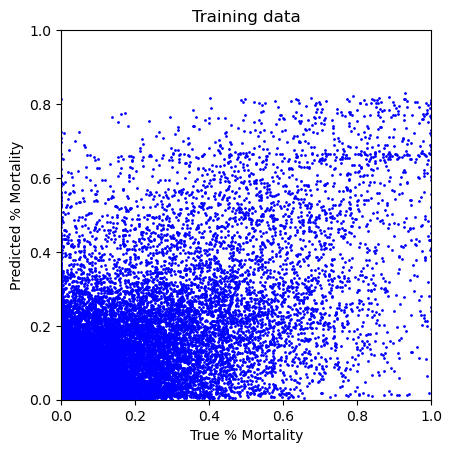

In [14]:
def one_to_one_plot(y_actual, y_predicted, ax=None):
    if ax is None:
        _, ax = plt.subplots()
        
    ax.scatter(y_actual, y_predicted, s=1, c="b")
    ax.set_xlabel("True % Mortality")
    ax.set_ylabel("Predicted % Mortality")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect("equal")
    return ax

one_to_one_plot(y_train, y_train_hat)
plt.title("Training data")
plt.show()

### Evaluate on test data

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Text(0.5, 1.0, 'Test data')

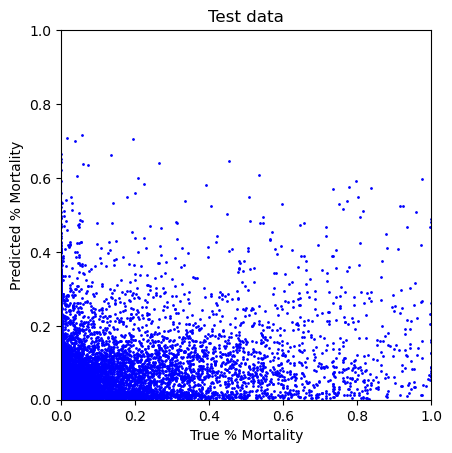

In [15]:
y_test = ds_test[TARGET].squeeze()
y_test_hat = model.predict(X_test, batch_size=batch_size).squeeze()

one_to_one_plot(y_test, y_test_hat)
plt.title("Test data")

In [16]:
# Performance statistics
r2 = (np.corrcoef(y_test, y_test_hat) ** 2)[0, 1]
rmse = np.sqrt(np.mean(np.power(y_test - y_test_hat, 2)))
print("R2 score: {:.2f}".format(r2))
print("RMSE: {:.3f}".format(rmse))

R2 score: 0.09
RMSE: 0.141


In [20]:
# Make a map
import xarray as xr
import cartopy.crs as ccrs

ds_test["mortality_predict"] = y_test_hat

ds_test_xr = xr.Dataset.from_dataframe(ds_test.set_index(["latitude", "longitude", "year"]))
ds_test_xr

<xarray.Dataset> Size: 14MB
Dimensions:            (latitude: 329, longitude: 224, year: 2)
Coordinates:
  * latitude           (latitude) float64 3kB 32.66 32.69 32.72 ... 41.98 42.01
  * longitude          (longitude) float64 2kB -124.3 -124.3 ... -116.4 -116.3
  * year               (year) int64 16B 2005 2015
Data variables:
    fire               (latitude, longitude, year) float64 1MB nan nan ... nan
    mort               (latitude, longitude, year) float64 1MB nan nan ... nan
    mort1              (latitude, longitude, year) float64 1MB nan nan ... nan
    mtemp1             (latitude, longitude, year) float64 1MB nan nan ... nan
    near1              (latitude, longitude, year) float64 1MB nan nan ... nan
    prec1              (latitude, longitude, year) float64 1MB nan nan ... nan
    prec2              (latitude, longitude, year) float64 1MB nan nan ... nan
    prec3              (latitude, longitude, year) float64 1MB nan nan ... nan
    prec4              (latitude, longitude, year) float64 1MB nan nan ... nan
    prism_prec         (latitude, longitude, year) float64 1MB nan nan ... nan
    rhost1             (latitude, longitude, year) float64 1MB nan nan ... nan
    mortality_predict  (latitude, longitude, year) float32 590kB nan nan ... nan

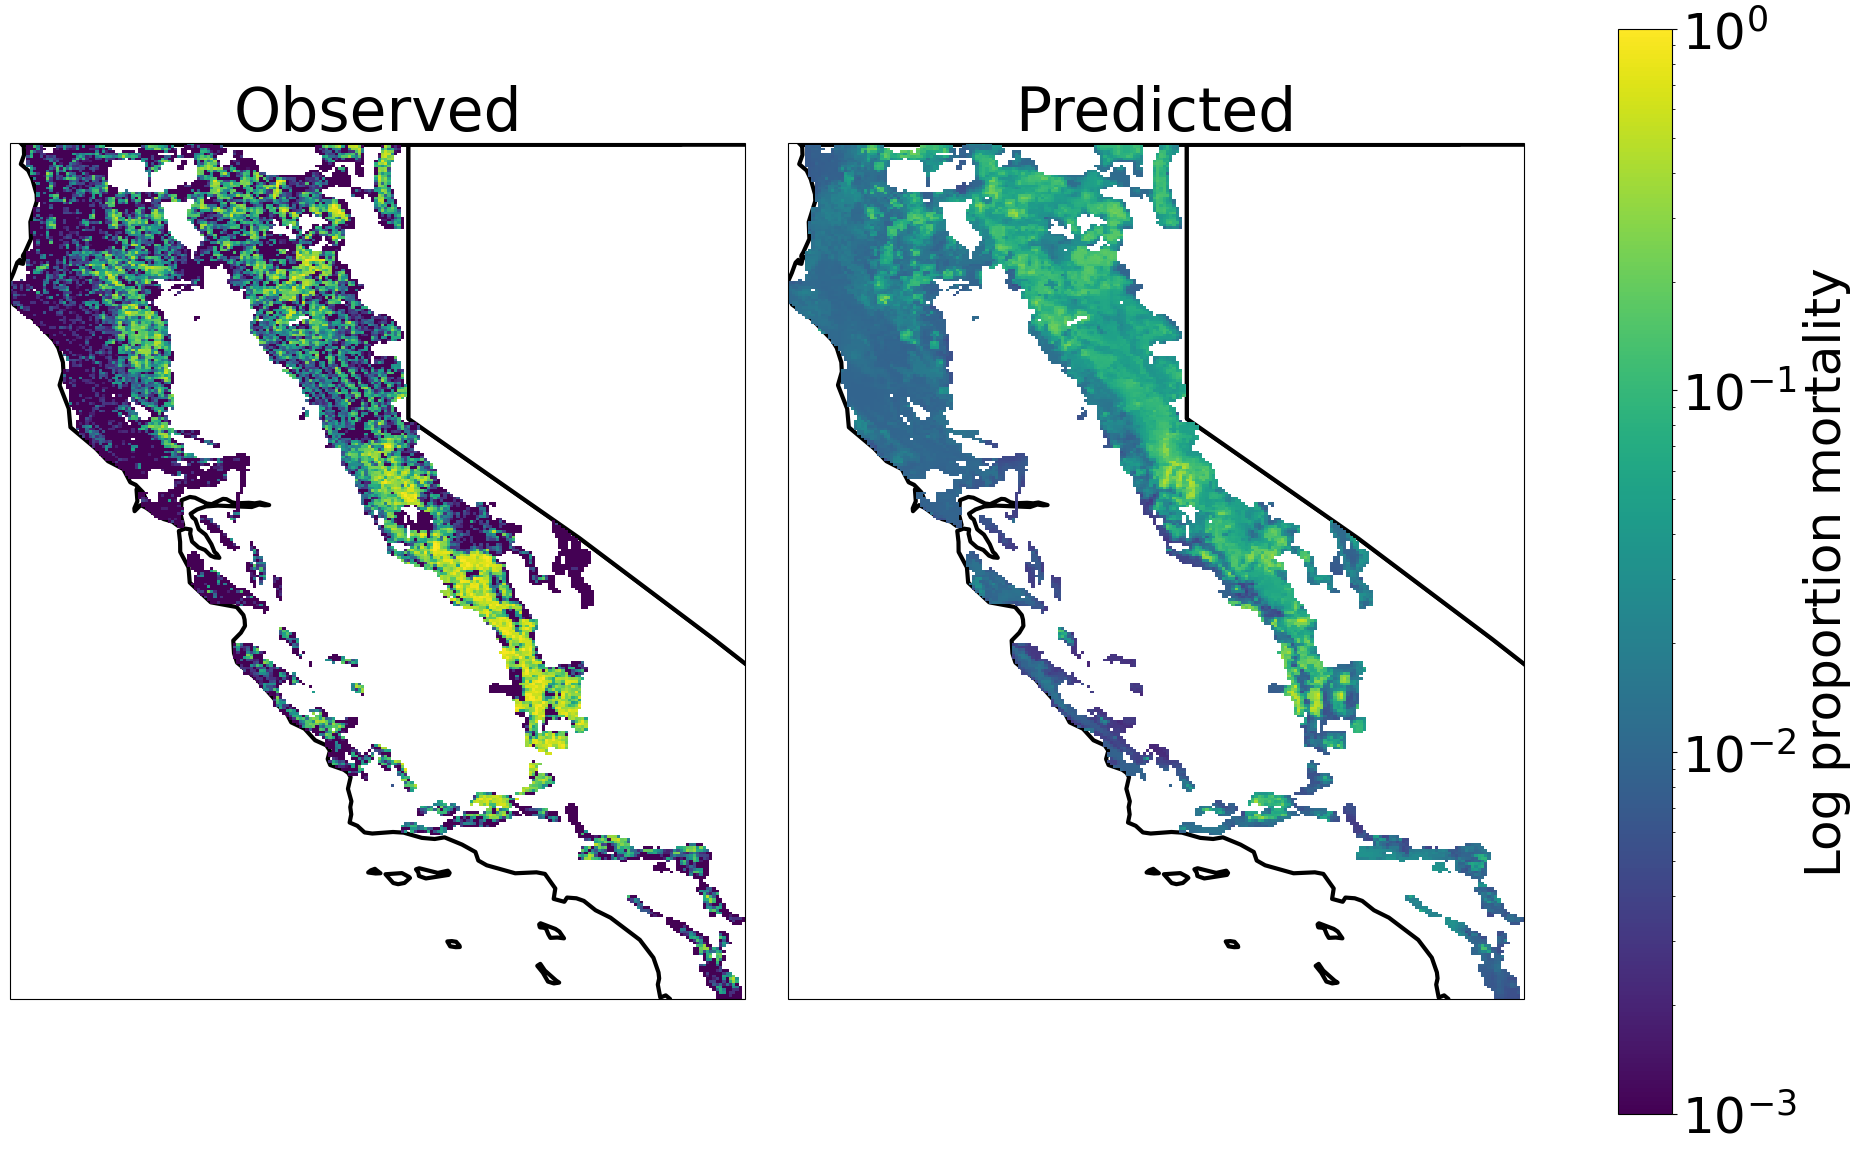

In [23]:
from matplotlib.colors import LogNorm
import cartopy.feature as cfeature

plt.rcParams.update({"font.size": 36})

fig = plt.figure(figsize=(20, 12))

mercator_proj = ccrs.PlateCarree()
ax1 = fig.add_subplot(1, 2, 1, projection=mercator_proj)
ax2 = fig.add_subplot(1, 2, 2, projection=mercator_proj)

# Get state bordesr
state_borders = cfeature.NaturalEarthFeature(
    category='cultural', 
    name='admin_1_states_provinces_lakes', 
    scale='50m', facecolor='#FFFFFF'
)

# Draw predictions
eps = 1e-3
norm = LogNorm(vmin=eps, vmax=1)

mort = ds_test_xr.sel(year=test_years[1])[TARGET[0]] + eps
pred = ds_test_xr.sel(year=test_years[1]).mortality_predict + eps

ax1.add_feature(state_borders, edgecolor="black", linewidth=3, zorder=0)
ax2.add_feature(state_borders, edgecolor="black", linewidth=3, zorder=0)
_  = mort.plot(ax=ax1, add_colorbar=False, norm=norm)
im = pred.plot(ax=ax2, add_colorbar=False, norm=norm)
ax1.set_title("Observed")
ax2.set_title("Predicted")
ax1.set_facecolor("white")
ax2.set_facecolor("white")
plt.tight_layout()
fig.colorbar(im, ax=[ax1, ax2], label="Log proportion mortality", location="right")
# plt.show()
fig.patch.set_alpha(0.0)
# fig.savefig("map.png")

### Learning curve

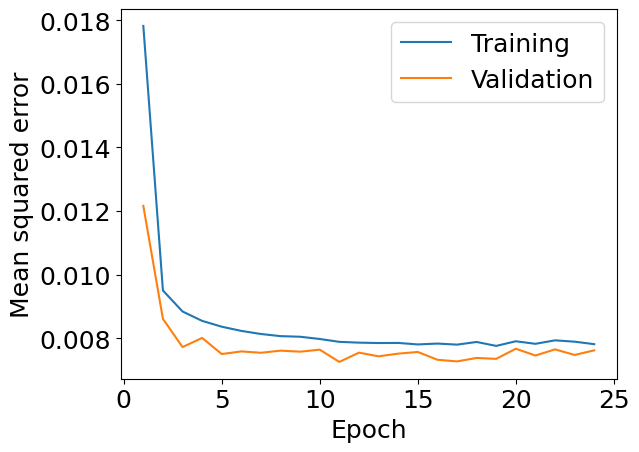

In [24]:
plt.rcParams.update({"font.size": 18})
plt.plot(np.arange(1, len(history.history["loss"])+1), history.history["loss"], label="Training")
plt.plot(np.arange(1, len(history.history["val_loss"])+1), history.history["val_loss"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.legend()
plt.show()

### All one-to-ones

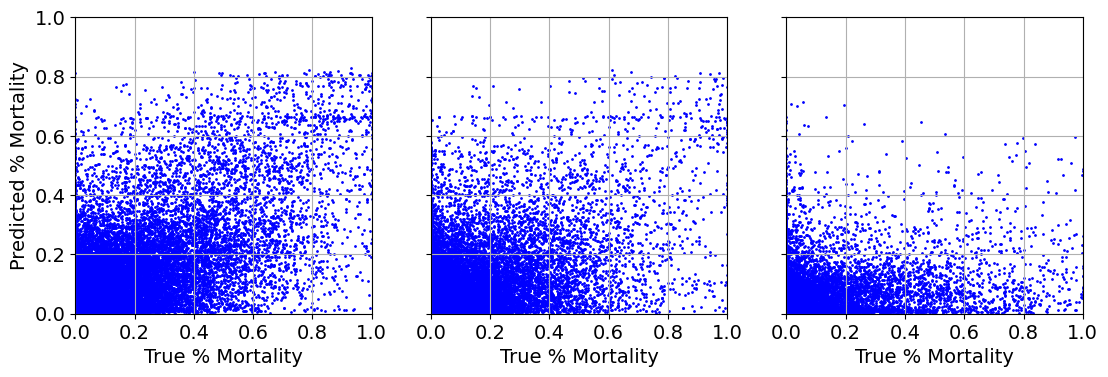

In [25]:
plt.rcParams.update({"font.size": 14})
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 6), sharex=True, sharey=True)

ax1 = one_to_one_plot(y_train, y_train_hat, ax=ax1)
ax2 = one_to_one_plot(y_valid, y_valid_hat, ax=ax2)
ax3 = one_to_one_plot(y_test, y_test_hat, ax=ax3)

ax2.set_ylabel("")
ax3.set_ylabel("")

ax1.grid()
ax2.grid()
ax3.grid()

plt.show()

### Modeling extents

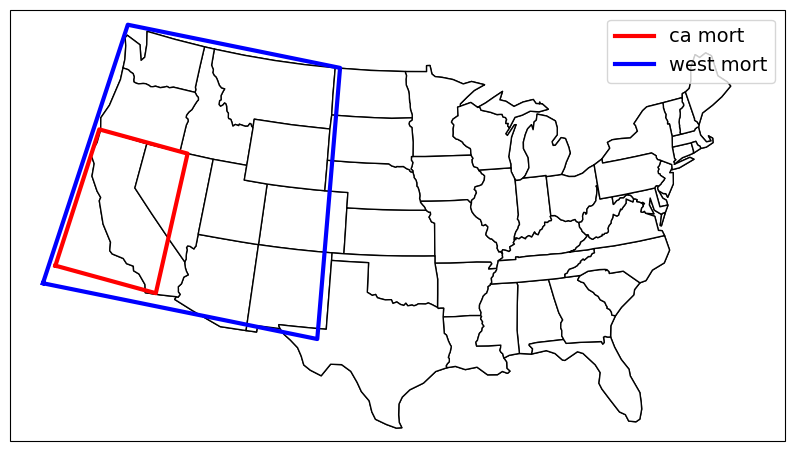

In [28]:
import cartopy.io.shapereader as shpreader
import matplotlib.patches as mpatches

west_xmin, west_ymin, west_xmax, west_ymax = (-124.83182873097032, 31.31942505180775, -103.62260487290841, 49.0320562417854)

ca_xmin, ca_ymin, ca_xmax, ca_ymax = (
    ds_test_xr.longitude.min().values,
    ds_test_xr.latitude.min().values,
    ds_test_xr.longitude.max().values,
    ds_test_xr.latitude.max().values
)

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.LambertConformal())

shapename = 'admin_1_states_provinces_lakes'
states_shp = shpreader.natural_earth(
    resolution='110m',
    category='cultural', 
    name=shapename
)

ax.add_geometries(
    shpreader.Reader(states_shp).geometries(),
    ccrs.PlateCarree(),
    styler=lambda x: {"facecolor": "#FFFFFF", "edgecolor": "black"}
)

ax.add_geometries(
    shpreader.Reader(states_shp).geometries(),
    ccrs.PlateCarree(),
    styler=lambda x: {"facecolor": "#FFFFFF", "edgecolor": "black"}
)

ax.plot(
    [ca_xmin, ca_xmax, ca_xmax, ca_xmin, ca_xmin],
    [ca_ymin, ca_ymin, ca_ymax, ca_ymax, ca_ymin],
    color="red",
    linewidth=3,
    transform=ccrs.Geodetic(),
    label="ca mort"
)


ax.plot(
    [west_xmin, west_xmax, west_xmax, west_xmin, west_xmin],
    [west_ymin, west_ymin, west_ymax, west_ymax, west_ymin],
    color="blue",
    linewidth=3,
    transform=ccrs.Geodetic(),
    label="west mort"
)

ax.set_extent([-125, -70, 25, 50], crs=ccrs.PlateCarree())
plt.legend()
plt.show()